In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from ipynb.fs.full.util import get_df_splits
from ipynb.fs.full.util import get_feature_importances
from ipynb.fs.full.util import run_classifier
from ipynb.fs.full.util import run_classifier_cv
from ipynb.fs.full.util import to_X_y
from ipynb.fs.full.util import to_X_y_tt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 10000)
pd.set_option("display.max_rows", None)

In [3]:
df = pd.read_csv("../data/dataset_cleaned.csv", na_values=["_NULL_"], keep_default_na=False)

In [4]:
df = df[
    (df["test_outcome"] == "positive")
    | (df["test_outcome"] == "negative")
    | (df["test_outcome"] == "indeterminate")
    | (df["test_outcome"] == "*missing")
]
display(df.shape)

(115347, 14)

In [5]:
df_splits = get_df_splits(df)

X_y_splits = []
for df_train, df_test in df_splits:
    vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
    X_train, X_test, y_train, y_test, _ = to_X_y_tt(vectorizer, df_train, df_test, "test_outcome")
    
    X_y_splits.append((X_train, X_test, y_train, y_test, df_test))

In [6]:
classifier_factories = [
    MultinomialNB,
    lambda: LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto"),
    lambda: RandomForestClassifier(n_estimators=100, random_state=1731, n_jobs=-1),
    lambda: LinearSVC(random_state=1731, max_iter=10000)
]

accuracies = []
errors = []
for index, classifier_factory in enumerate(classifier_factories):
    accuracy, confusion, precision, recall, error = run_classifier_cv(classifier_factory, X_y_splits, ["positive", "negative", "indeterminate", "*missing"])
    accuracies.append(accuracy)
    errors.append(error)
    
    display(f"Classifier {index + 1}")
    display(accuracy)
    display(confusion)
    display(precision)
    display(recall)

'Classifier 1'

0.9233270208785264

array([[16693,   460,   946,  1150],
       [  156, 13789,  1147,   176],
       [   13,   100,  1297,    43],
       [  342,  1980,  2331, 74724]])

array([0.97029761, 0.84444853, 0.22670862, 0.98200886])

array([0.86721388, 0.90313073, 0.89263593, 0.941381  ])

'Classifier 2'

0.9913825369597096

array([[19023,    56,    43,   127],
       [   57, 15019,    53,   139],
       [   38,    72,  1268,    75],
       [  105,   170,    59, 79043]])

array([0.9895958 , 0.98054449, 0.89107519, 0.99570442])

array([0.98825913, 0.98369138, 0.87267722, 0.99579223])

'Classifier 3'

0.9924402097602709

array([[18989,    73,    37,   150],
       [   57, 15084,    36,    91],
       [   43,    66,  1257,    87],
       [   74,    90,    68, 79145]])

array([0.99092   , 0.98504539, 0.89914163, 0.99587281])

array([0.9864928 , 0.98794865, 0.86510668, 0.99707724])

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


'Classifier 4'

0.9917033047406093

array([[19034,    74,    36,   105],
       [   53, 15037,    49,   129],
       [   35,    76,  1282,    60],
       [  101,   178,    61, 79037]])

array([0.99016803, 0.97865278, 0.8977591 , 0.99629401])

array([0.98883059, 0.98487032, 0.88231246, 0.99571664])

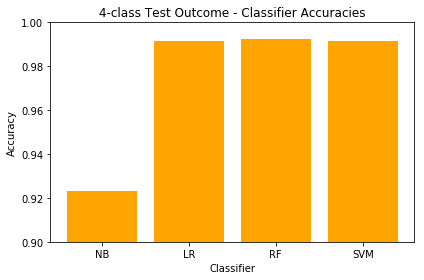

In [7]:
X = ["NB", "LR", "RF", "SVM"]
n = len(X)

plt.bar(range(n), accuracies, align="center", color="orange")

plt.xticks(range(n), X)
plt.ylim(0.9, 1)

plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("4-class Test Outcome - Classifier Accuracies")

plt.tight_layout()
plt.savefig("../figs/4cto_accuracies.png")

In [ ]:
errors[3]

In [9]:
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X, y, feature_names = to_X_y(vectorizer, df, "test_outcome")

classifier = RandomForestClassifier(n_estimators=100, random_state=1731, n_jobs=-1)
classifier.fit(X, y)

feature_importances = get_feature_importances(classifier, feature_names)

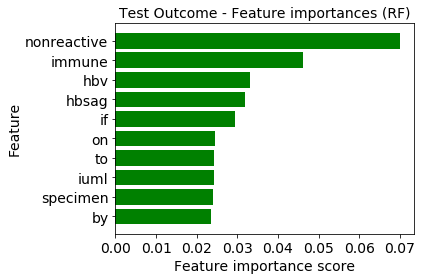

In [10]:
y = [-x for x in range(len(feature_importances))]
width = [x[1] for x in feature_importances]

plt.barh(y, width, color="green")

feature_names = [x[0] for x in feature_importances]
plt.xticks(fontsize=14)
plt.yticks(y, feature_names, fontsize=14)

plt.xlabel("Feature importance score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Test Outcome - Feature importances (RF)", fontsize=14)

plt.tight_layout()
plt.savefig("../figs/4cto_rf_features.png")

In [11]:
classifier_factories = [
    MultinomialNB,
    lambda: LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto"),
    lambda: RandomForestClassifier(n_estimators=100, random_state=1731, n_jobs=-1),
    lambda: LinearSVC(random_state=1731, max_iter=10000)
]

accuracies = [[], [], [], []]

sizes = list(range(50, 5000 + 1, 50))
for size in sizes:
    df_train, df_test = train_test_split(df, train_size=size, random_state=1731, shuffle=True)
    
    vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
    X_train, X_test, y_train, y_test, _ = to_X_y_tt(vectorizer, df_train, df_test, "test_outcome")
    
    for index, classifier_factory in enumerate(classifier_factories):
        classifier = classifier_factory()
        accuracy, _, _, _, _ = run_classifier(
            classifier, X_train, X_test, y_train, y_test, df_test,
            ["positive", "negative", "indeterminate", "*missing"]
        )
        accuracies[index].append(accuracy)

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selectio

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selectio

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selectio

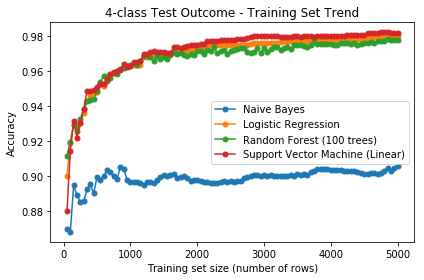

In [12]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
labels = ["Naive Bayes", "Logistic Regression", "Random Forest (100 trees)", "Support Vector Machine (Linear)"]

handles = []

for i in range(4):
    color = colors[i % len(colors)]

    line, = plt.plot(sizes, accuracies[i], marker="o", markersize=5, label=labels[i], color=color)
    handles.append(line)

plt.title("4-class Test Outcome - Training Set Trend")
plt.xlabel("Training set size (number of rows)")
plt.ylabel("Accuracy")
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig("../figs/4cto_training_set_trend.png")

In [13]:
classifier_factories = [
    MultinomialNB,
    lambda: LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto"),
    lambda: RandomForestClassifier(n_estimators=100, random_state=1731, n_jobs=-1),
    lambda: LinearSVC(random_state=1731, max_iter=10000)
]

accuracies = [[], [], [], []]

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X, y, feature_names = to_X_y(vectorizer, df, "test_outcome")

num_features = list(range(10, 200 + 1, 10))
for k in num_features:
    # -------------------
    # select the features
    
    select = SelectKBest(chi2, k=k)
    select.fit(X, y)
    
    support = select.get_support(indices=True)
    vocabulary = [feature_names[index] for index in support]
    
    # -------------------------------------------
    # evaluate performance using cross-validation
    
    df_splits = get_df_splits(df)

    X_y_splits = []
    for df_train, df_test in df_splits:
        vectorizer = CountVectorizer(vocabulary=vocabulary)
        X_train, X_test, y_train, y_test, _ = to_X_y_tt(vectorizer, df_train, df_test, "test_outcome")

        X_y_splits.append((X_train, X_test, y_train, y_test, df_test))
    
    for index, classifier_factory in enumerate(classifier_factories):
        accuracy, _, _, _, _ = run_classifier_cv(
            classifier_factory, X_y_splits,
            ["positive", "negative", "indeterminate", "*missing"]
        )
        accuracies[index].append(accuracy)

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: C

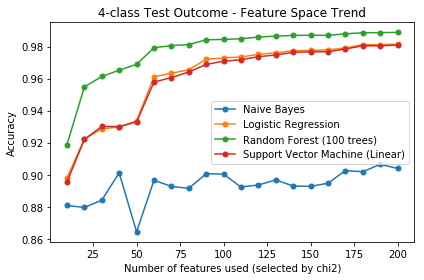

In [14]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
labels = ["Naive Bayes", "Logistic Regression", "Random Forest (100 trees)", "Support Vector Machine (Linear)"]

handles = []

for i in range(4):
    color = colors[i % len(colors)]

    line, = plt.plot(num_features, accuracies[i], marker="o", markersize=5, label=labels[i], color=color)
    handles.append(line)

plt.title("4-class Test Outcome - Feature Space Trend")
plt.xlabel("Number of features used (selected by chi2)")
plt.ylabel("Accuracy")
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig("../figs/4cto_feature_space_trend.png")